<a href="https://colab.research.google.com/github/ericyoc/steganography_text_image_poc/blob/main/steganography_text_image_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab setup cell — run this first
!pip install pillow tqdm --quiet

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enter password for embedding/extraction (short): secret
Enter text to hide (short): This is a secret


Embedding bits:   0%|          | 200/151875 [00:00<00:00, 332353.72pos/s]


[OK] Text stego saved to /content/drive/MyDrive/stego/cover_with_text.png


Embedding bits:  47%|████▋     | 71136/151875 [00:00<00:00, 535186.63pos/s]


[OK] Image stego saved to /content/drive/MyDrive/stego/cover_with_image.png
[STEP] Visualizing text stego diff...


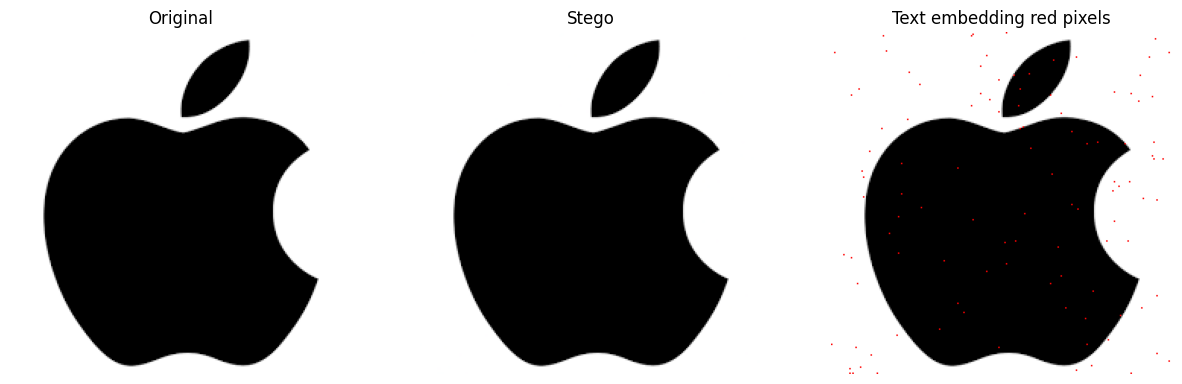

[STEP] Visualizing image stego diff...


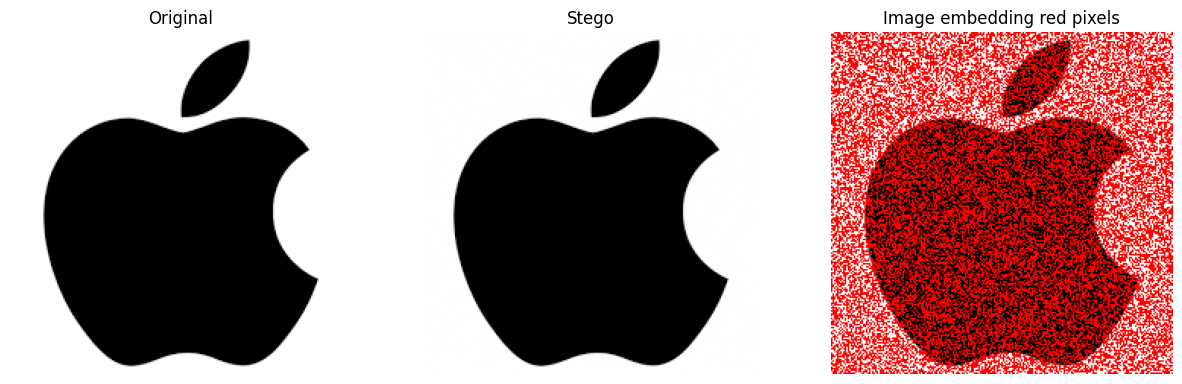

[STEP] Extracting text payload...


Reading bits from stego:   0%|          | 200/151875 [00:00<00:01, 97383.42pos/s]

Extracted text: This is a secret


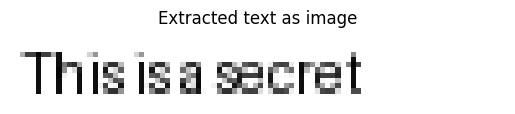

[STEP] Extracting image payload...


Reading bits from stego:  47%|████▋     | 71136/151875 [00:00<00:00, 121705.25pos/s]


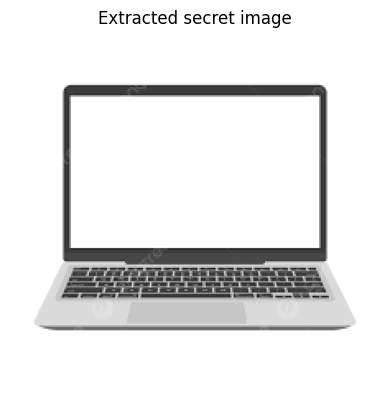

In [12]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import hashlib
import struct
from io import BytesIO
import matplotlib.pyplot as plt

# ------------------ Helper functions ------------------
def _to_bitarray(data_bytes):
    bits = []
    for b in data_bytes:
        for i in range(7,-1,-1):
            bits.append((b>>i)&1)
    return bits

def _bits_to_bytes(bits):
    if len(bits)%8 !=0:
        bits += [0]*(8 - len(bits)%8)
    out = bytearray()
    for i in range(0,len(bits),8):
        byte = 0
        for b in bits[i:i+8]:
            byte = (byte<<1)|b
        out.append(byte)
    return bytes(out)

def _seed_from_password(password):
    h = hashlib.sha256(password.encode('utf-8')).digest()
    return int.from_bytes(h[:8],'big')

def capacity_pixels(img_shape,bits_to_use=1):
    if len(img_shape)==3:
        h,w,c = img_shape
    elif len(img_shape)==2:
        h,w = img_shape
        c=3
    else:
        raise ValueError("Unsupported shape")
    total_bits = h*w*c*bits_to_use
    return total_bits//8

def _prepare_payload_bytes(payload_type,payload_bytes):
    magic = b'STEG'
    ptype = b'\x00' if payload_type=='text' else b'\x01'
    length = struct.pack('>I',len(payload_bytes))
    return magic+ptype+length+payload_bytes

def embed_bytes_into_image(cover_img,payload_bytes,password="",bits_to_use=1):
    cover = cover_img.convert('RGB')
    arr = np.array(cover).astype(np.uint8)
    h,w,c = arr.shape
    total_channels = h*w*c
    payload_bits = _to_bitarray(payload_bytes)
    rng = np.random.default_rng(_seed_from_password(password))
    perm = rng.permutation(total_channels)
    out = arr.copy()
    idx = 0
    for channel_pos in tqdm(perm, desc="Embedding bits", unit="pos"):
        if idx>=len(payload_bits):
            break
        pixel_index = channel_pos//c
        ch = channel_pos%c
        y = pixel_index//w
        x = pixel_index%w
        val = int(out[y,x,ch])
        mask = (~((1<<bits_to_use)-1))&0xFF
        val_cleared = val&mask
        bits_chunk = 0
        for _ in range(bits_to_use):
            if idx<len(payload_bits):
                bits_chunk = (bits_chunk<<1)|payload_bits[idx]
                idx+=1
            else:
                bits_chunk = (bits_chunk<<1)|0
        out[y,x,ch]= val_cleared|bits_chunk
    return Image.fromarray(out)

def embed_text(cover_path,output_path,text,password,bits_to_use=1):
    cover = Image.open(cover_path)
    payload_bytes = text.encode('utf-8')
    prepared = _prepare_payload_bytes('text',payload_bytes)
    stego = embed_bytes_into_image(cover,prepared,password,bits_to_use)
    stego.save(output_path)
    print(f"[OK] Text stego saved to {output_path}")
    return stego

def embed_image(cover_path,output_path,secret_path,password,bits_to_use=1):
    cover = Image.open(cover_path)
    arr = np.array(cover.convert('RGB'))
    h,w,c = arr.shape
    secret = Image.open(secret_path).convert('RGBA')
    bio = BytesIO()
    secret.save(bio,format='PNG')
    secret_bytes = bio.getvalue()
    max_capacity = capacity_pixels((h,w,c),bits_to_use)-64
    if len(secret_bytes)>max_capacity:
        raise ValueError("Secret image too large")
    prepared = _prepare_payload_bytes('image',secret_bytes)
    stego = embed_bytes_into_image(cover,prepared,password,bits_to_use)
    stego.save(output_path)
    print(f"[OK] Image stego saved to {output_path}")
    return stego

def extract_payload_from_stego_only(modified_path,password,bits_to_use=1):
    mod = Image.open(modified_path).convert('RGB')
    a_mod = np.array(mod).astype(np.uint8)
    h,w,c = a_mod.shape
    total_channels = h*w*c
    rng = np.random.default_rng(_seed_from_password(password))
    perm = rng.permutation(total_channels)
    mod_bits=[]
    for channel_pos in tqdm(perm, desc="Reading bits from stego", unit="pos"):
        if len(mod_bits)>=72:
            header_bytes = _bits_to_bytes(mod_bits[:72])
            if header_bytes[:4]==b'STEG':
                payload_len = struct.unpack('>I',header_bytes[5:9])[0]
                total_bits_needed = (9+payload_len)*8
                if len(mod_bits)>=total_bits_needed:
                    break
        pixel_index = channel_pos//c
        ch = channel_pos%c
        y = pixel_index//w
        x = pixel_index%w
        val = int(a_mod[y,x,ch])
        for shift in range(bits_to_use-1,-1,-1):
            mod_bits.append((val>>shift)&1)
    header_bytes = _bits_to_bytes(mod_bits[:72])
    if header_bytes[:4]!=b'STEG':
        print("[WARN] No STEG header found")
        return None,None
    payload_type = 'text' if header_bytes[4]==0 else 'image'
    payload_len = struct.unpack('>I',header_bytes[5:9])[0]
    payload_bytes = _bits_to_bytes(mod_bits[72:72+payload_len*8])
    return payload_type,payload_bytes

def visualize_diff(original,stego,explanation="Diff"):
    if original.mode!='RGB': original=original.convert('RGB')
    if stego.mode!='RGB': stego=stego.convert('RGB')
    orig_arr = np.array(original)
    stego_arr = np.array(stego)
    diff_mask = np.any(orig_arr!=stego_arr,axis=2)
    overlay = orig_arr.copy()
    overlay[diff_mask]=[255,0,0]
    fig,axes = plt.subplots(1,3,figsize=(15,5))
    axes[0].imshow(original); axes[0].set_title("Original"); axes[0].axis('off')
    axes[1].imshow(stego); axes[1].set_title("Stego"); axes[1].axis('off')
    axes[2].imshow(overlay); axes[2].set_title(explanation); axes[2].axis('off')
    plt.show()

def render_text_image(text):
    # Simple function to render text to image
    font = ImageFont.load_default()
    lines = text.split('\n')
    width = max([len(line) for line in lines])*6
    height = 10*len(lines)+4
    img = Image.new('RGB',(width,height),(255,255,255))
    draw = ImageDraw.Draw(img)
    draw.text((2,2),text,fill=(0,0,0),font=font)
    return img

# ------------------ Main function ------------------
def main():
    cover_path = "/content/drive/MyDrive/stego/cover_image.png"
    secret_path = "/content/drive/MyDrive/stego/secret_image.png"
    text_stego_path = "/content/drive/MyDrive/stego/cover_with_text.png"
    image_stego_path = "/content/drive/MyDrive/stego/cover_with_image.png"
    extraction_dir = "/content/drive/MyDrive/stego/extracted"
    os.makedirs(extraction_dir,exist_ok=True)

    password = input("Enter password for embedding/extraction (short): ")
    hidden_text = input("Enter text to hide (short): ")

    # Embed text
    stego_text_img = embed_text(cover_path,text_stego_path,hidden_text,password,bits_to_use=1)
    # Embed image
    if os.path.exists(secret_path):
        stego_image_img = embed_image(cover_path,image_stego_path,secret_path,password,bits_to_use=1)
    else:
        print("[INFO] Secret image not found, skipping image embedding.")
        stego_image_img = None

    # Visualize embedding diffs
    print("[STEP] Visualizing text stego diff...")
    visualize_diff(Image.open(cover_path),stego_text_img,"Text embedding red pixels")

    if stego_image_img:
        print("[STEP] Visualizing image stego diff...")
        visualize_diff(Image.open(cover_path),stego_image_img,"Image embedding red pixels")

    # Extract text
    print("[STEP] Extracting text payload...")
    ptype,pbytes = extract_payload_from_stego_only(text_stego_path,password)
    if ptype=='text':
        extracted_text = pbytes.decode('utf-8')
        print("Extracted text:",extracted_text)
        text_img = render_text_image(extracted_text)
        plt.imshow(text_img); plt.title("Extracted text as image"); plt.axis('off'); plt.show()
    # Extract secret image
    if stego_image_img:
        print("[STEP] Extracting image payload...")
        ptype,pbytes = extract_payload_from_stego_only(image_stego_path,password)
        if ptype=='image':
            extracted_img = Image.open(BytesIO(pbytes))
            plt.imshow(extracted_img); plt.title("Extracted secret image"); plt.axis('off'); plt.show()

# Run main
if __name__=="__main__":
    main()